### Import Statements

In [101]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
from IPython.display import Image

In [102]:
# sample image file
img_file = '../data/creative_assets/0c1a2c286a6818e1354c2b655f68da09-ffb622dd70303838b356.png'

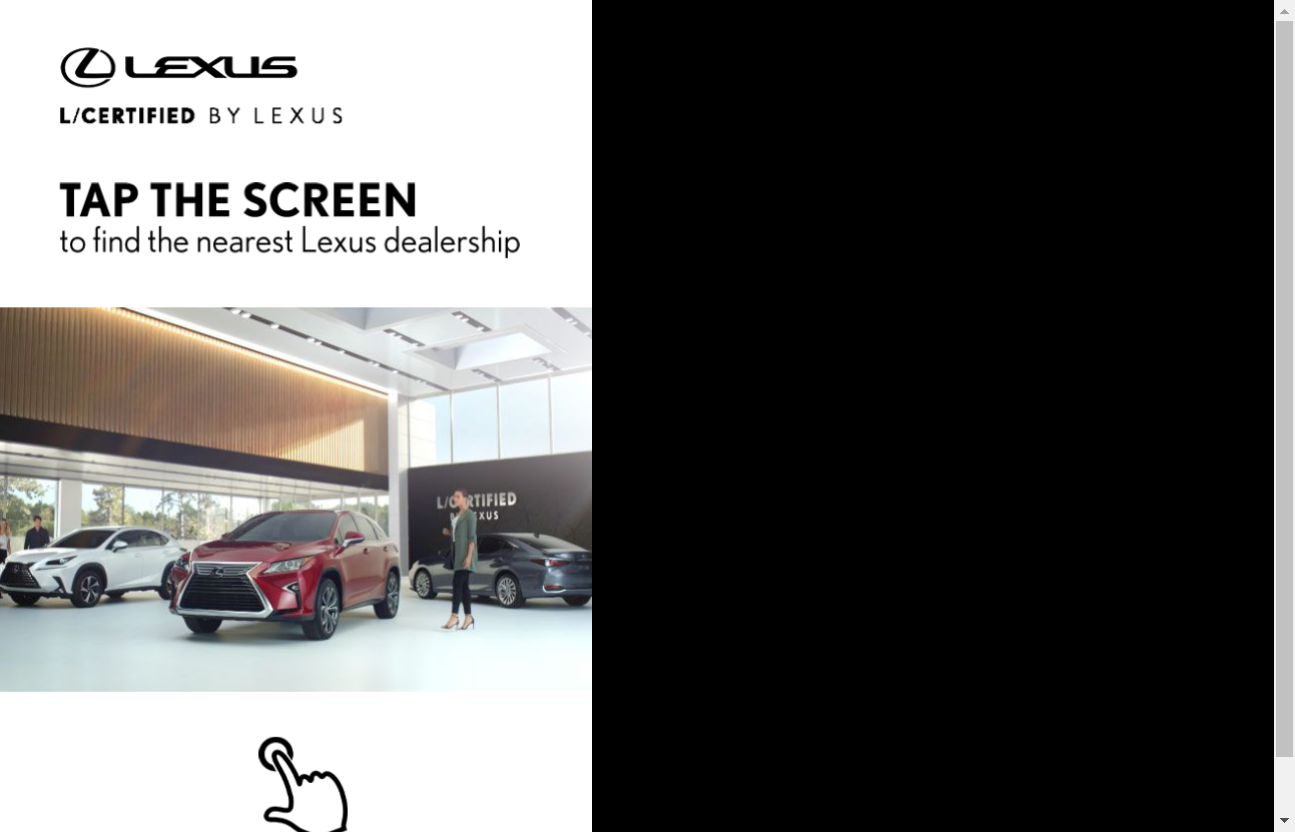

In [103]:
# preview image
img = cv2.imread(img_file)
Image(filename=img_file)

### Preprocessing

In [104]:
# gray scale
def gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(r"../data/creative_assets/preprocess/tesseract/img_gray.png",img)
    return img

# blur
def blur(img) :
    img_blur = cv2.GaussianBlur(img,(5,5),0)
    cv2.imwrite(r"../data/creative_assets/preprocess/tesseract/img_blur.png",img)
    return img_blur

# threshold
def threshold(img):
    # pixels with value below 100 are turned black (0) and those with higher value are turned white (255)
    img = cv2.threshold(img, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[1]
    cv2.imwrite(r"../data/creative_assets/preprocess/tesseract/img_threshold.png",img)
    return img

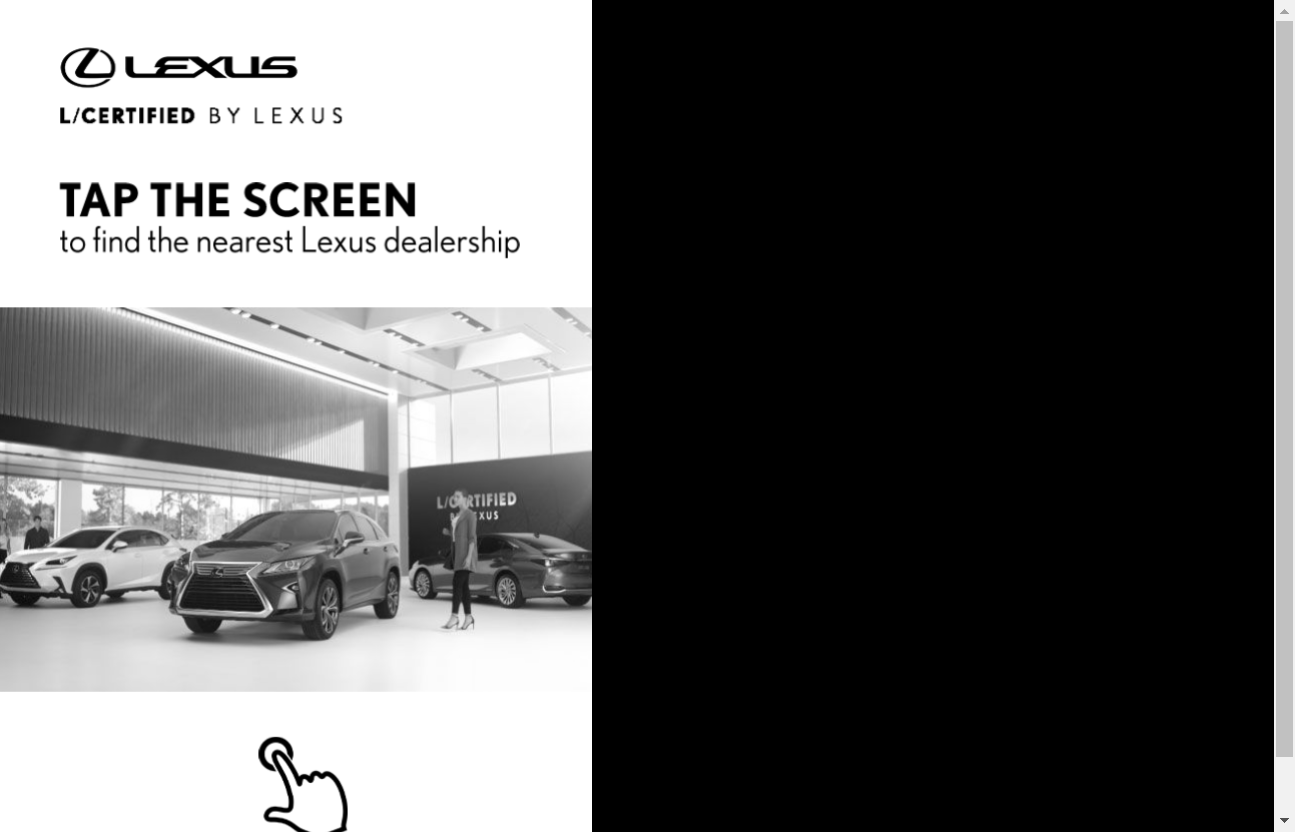

In [106]:
# preview gray scaled image
im_gray = gray(img)
Image(filename='../data/creative_assets/preprocess/tesseract/img_gray.png')

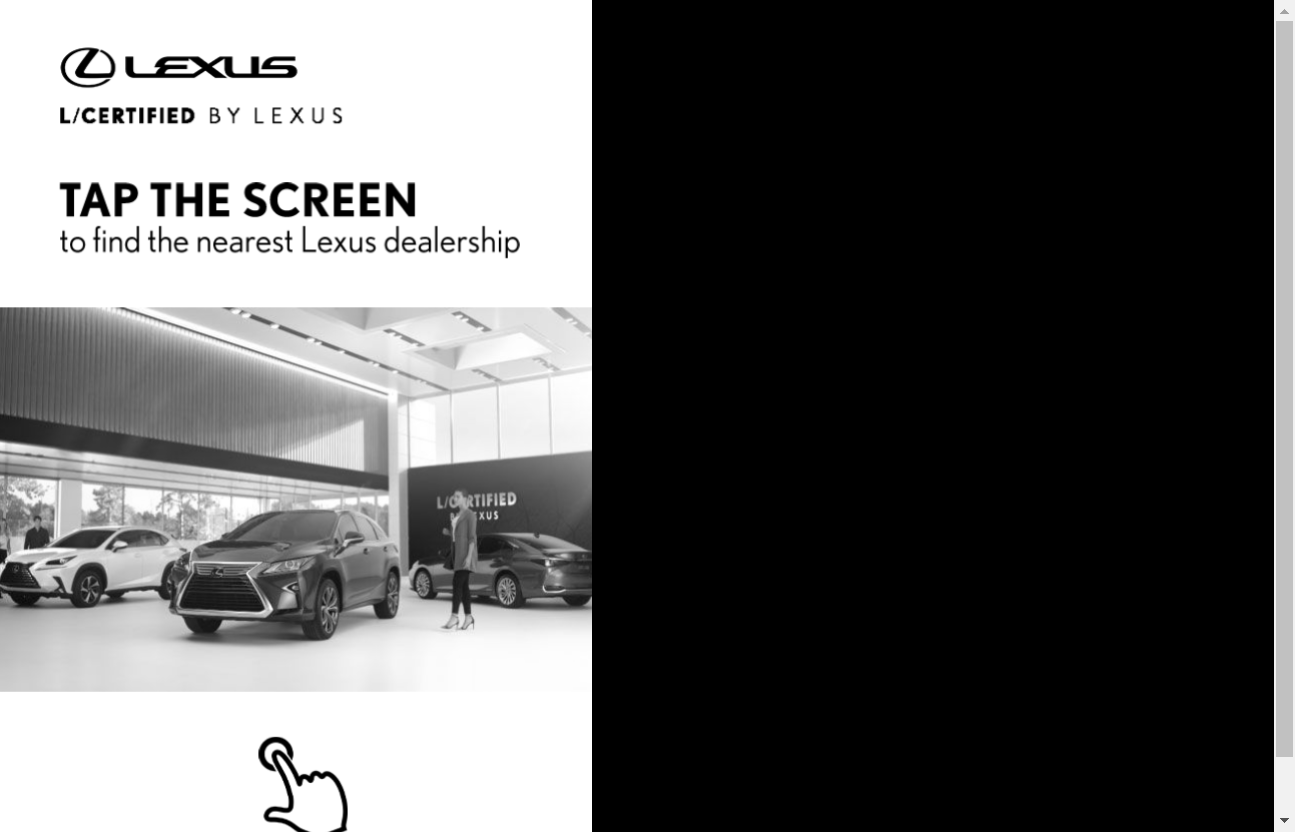

In [108]:
# preview gray scaled and blurred image
im_blur = blur(im_gray)
Image(filename='../data/creative_assets/preprocess/tesseract/img_blur.png')

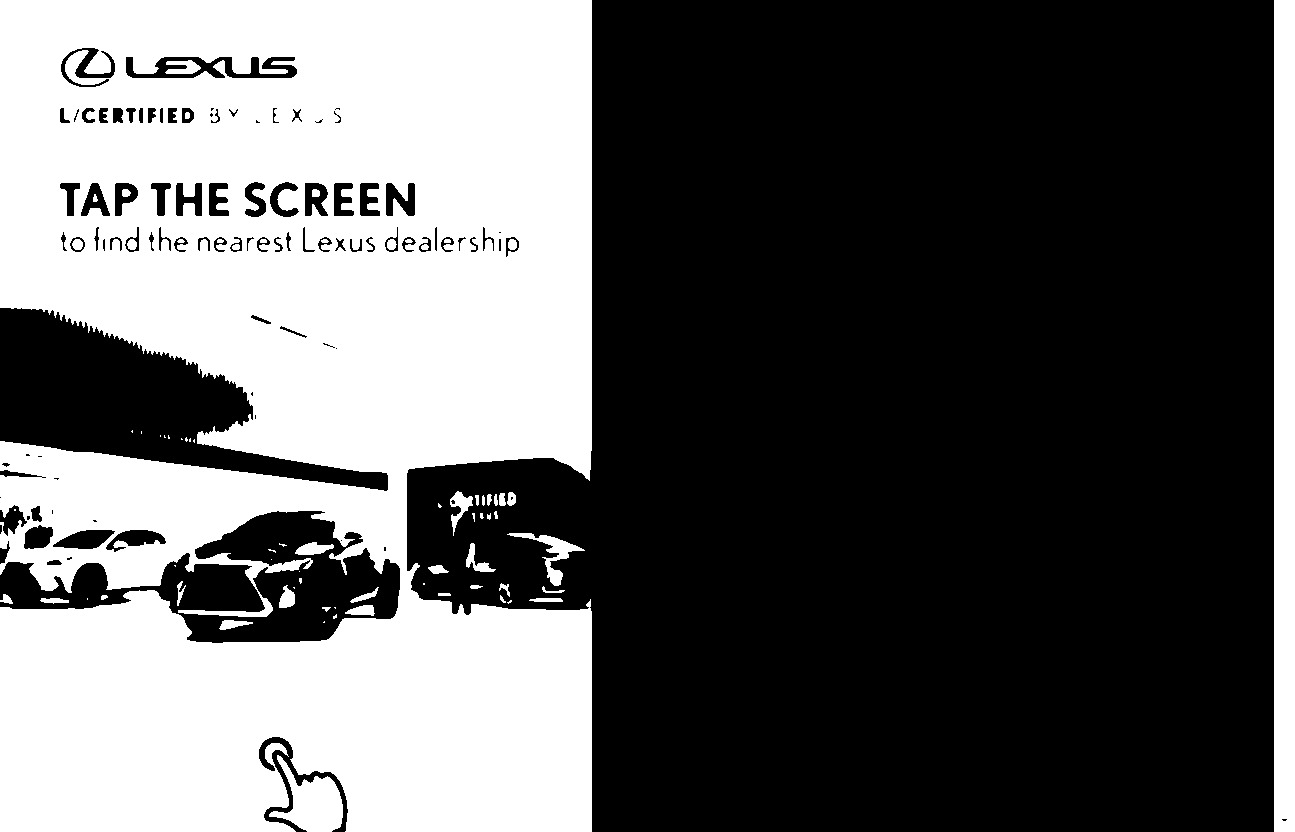

In [109]:
# preview gray scaled, blurred, and thresh image
im_thresh = threshold(im_blur)
Image(filename='../data/creative_assets/preprocess/tesseract/img_threshold.png')

In [110]:
# find curves joining all the continuous points, having same color or intensity
contours, _ = cv2.findContours(im_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

### Text Detection using OpenCV and Google’s Tesseract

###### Python-tesseract is a wrapper for Google’s Tesseract-OCR Engine

In [111]:
# initialize empty list to hold detected text
detected_text_list = []
def contours_text(original_img, contours):
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Drawing a rectangle on copied image
        rect = cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 255), 2)

        # cv2.imshow('cnt',rect)
        # cv2.waitKey()
        cv2.imwrite(r"../data/creative_assets/preprocess/tesseract/img_cnt.png",rect)

        # Cropping the text block for giving input to OCR
        cropped = original_img[y:y + h, x:x + w]

        # Apply OCR on the cropped image
        config = ('-l eng --oem 1 --psm 3')
        text = pytesseract.image_to_string(cropped, config=config)
        print(text)
        detected_text_list.append(text)

In [112]:
# detect text from image
contours_text(original_img= img, contours=contours)














































a S'












Ovexus
L/CERTIFIED BY LEXUS

TAP THE SCREEN

to find the nearest Lexus dealership




In [113]:
# detected text list
detected_text_list

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 "a S'\n\n",
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Ovexus\nL/CERTIFIED BY LEXUS\n\nTAP THE SCREEN\n\nto find the nearest Lexus dealership\n\n']

In [114]:
# filtered detected text list
filtered_detected_text_list = list(filter(None, detected_text_list))
filtered_detected_text_list

["a S'\n\n",
 'Ovexus\nL/CERTIFIED BY LEXUS\n\nTAP THE SCREEN\n\nto find the nearest Lexus dealership\n\n']

In [115]:
# preview image with contours
im_gray = gray(img)
Image(filename='../data/creative_assets/preprocess/img_cnt.png')

FileNotFoundError: [Errno 2] No such file or directory: '../data/creative_assets/preprocess/img_cnt.png'

### Text Detection using EAST

###### EAST, or Efficient and Accurate Scene Text Detector, is a deep learning model for detecting text from natural scene images. It is pretty fast and accurate as it is able to detect 720p images at 13.2fps with an F-score of 0.7820.

In [116]:
import os, sys
import numpy as np
import cv2
import time
from imutils.object_detection import non_max_suppression

def east_detect(image):
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]

    orig = image.copy()

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (320, 320)

    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))

    (H, W) = image.shape[:2]

    net = cv2.dnn.readNet("frozen_east_text_detection.pb")

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)

    start = time.time()

    net.setInput(blob)

    (scores, geometry) = net.forward(layerNames)

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
    		# if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
    		# compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
    	# scale the bounding box coordinates based on the respective
    	# ratios
    	startX = int(startX * rW)
    	startY = int(startY * rH)
    	endX = int(endX * rW)
    	endY = int(endY * rH)
    	# draw the bounding box on the image
    	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)


    print(time.time() - start)
    return orig

In [118]:
image = cv2.imread(img_file)

In [119]:
out_image = east_detect(image)

0.25612497329711914


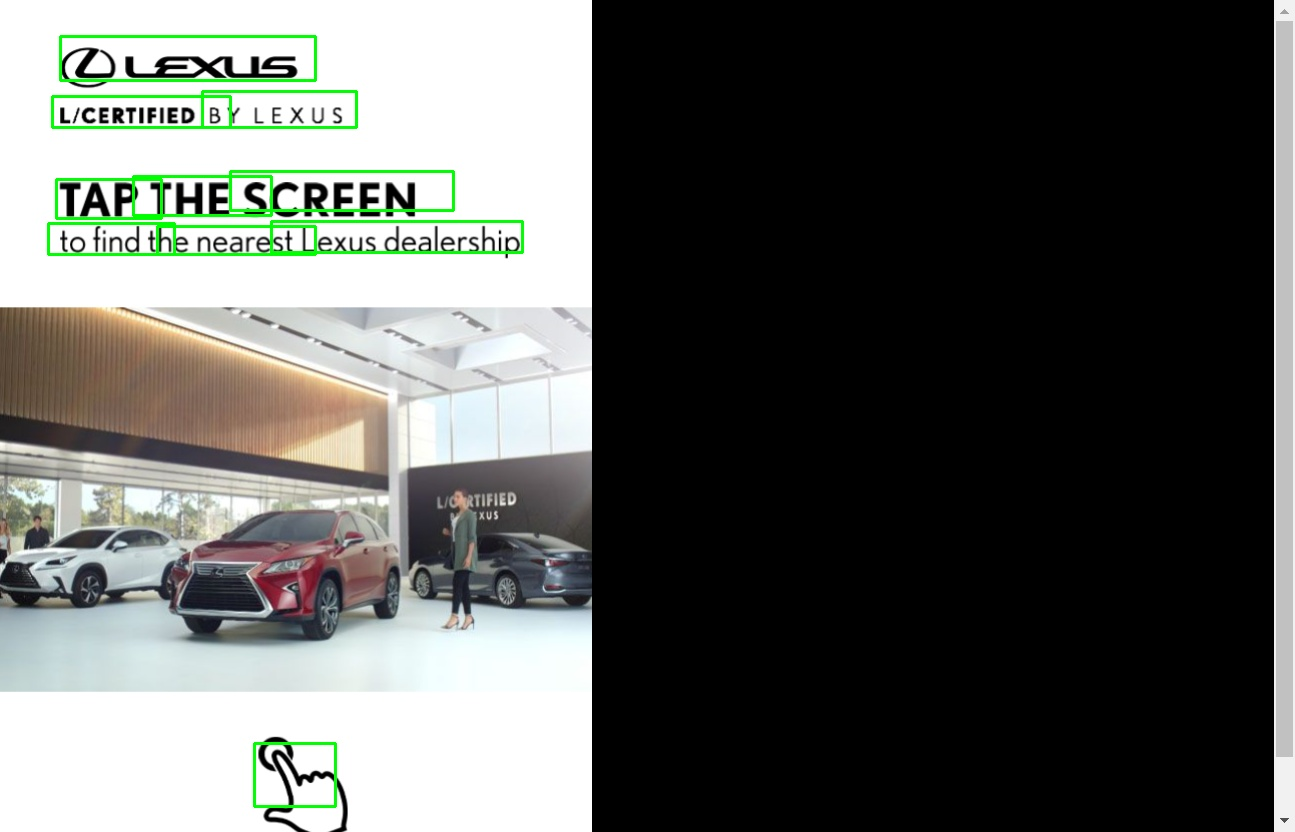

In [122]:
cv2.imwrite(r"../data/creative_assets/preprocess/east/sample_output.jpg", out_image)
Image(filename='../data/creative_assets/preprocess/east/sample_output.jpg')